In [1]:
import scipy.io
import numpy as np, os

def loadData(ROOT_PATH):
    mat1 = scipy.io.loadmat(ROOT_PATH + '/S001_128.mat')
    mat2 = scipy.io.loadmat(ROOT_PATH + '/S001_128_ann.mat')
    mat3 = scipy.io.loadmat(ROOT_PATH + '/S001_128_spk.mat')

    recording = np.asarray(mat1['ppg'], dtype=np.float64)

    # Get number of ann files contained in the folder
    path_ppgs_128 = []
    path_ppgs_250 = []
    for f in os.listdir(ROOT_PATH):
        g = os.path.join(ROOT_PATH, f)
        if not f.lower().startswith('.') and f.lower().endswith('_128.mat') and os.path.isfile(g):
            path_ppgs_128.append(g)
        elif not f.lower().startswith('.') and f.lower().endswith('_250.mat') and os.path.isfile(g):
            path_ppgs_250.append(g)

    num_files_128 = len(path_ppgs_128)
    num_files_250 = len(path_ppgs_250)

    '''
    print("cases 128: ")
    print(num_files_128)
    print("cases 250: ")
    print(num_files_250)
    print("Tot: ")
    print(num_files_128 + num_files_250)
    '''

    # Create empty list for annotation, peak position and ppg signals of files
    # Annotation: labels which can assume 3 values: N (Normal), V (Ventricular), S(SuperVentricular)
    # speaks: contains peak positions in samples
    # ppg: contains the ppg signal in samples
    annotations_128 = list()
    speaks_128 = list()
    ppgs_128 = list()

    # Load files for each subject using the function "loadmat"
    for i in range(num_files_128):
        print('Loading file: ' + str(i + 1) + '/' + str(num_files_128))
        root = path_ppgs_128[i].split("_")
        ppgMat = scipy.io.loadmat(path_ppgs_128[i])
        ppg = np.asarray(ppgMat['ppg'], dtype=np.float64)
        annotationMat = scipy.io.loadmat(root[0] + '_128_ann.mat')
        annotation = np.asarray(annotationMat['labels'])
        speaksMat = scipy.io.loadmat(root[0] + '_128_spk.mat')
        speaks = np.asarray(speaksMat['speaks'])

        annotations_128.append(annotation)
        speaks_128.append(speaks)
        ppgs_128.append(ppg)

    annotations_250 = list()
    speaks_250 = list()
    ppgs_250 = list()

    # Load files for each subject using the function "loadmat"
    for i in range(num_files_250):
        print('Loading file: ' + str(i + 1) + '/' + str(num_files_250))
        root = path_ppgs_250[i].split("_")
        ppgMat = scipy.io.loadmat(path_ppgs_250[i])
        ppg = np.asarray(ppgMat['ppg'], dtype=np.float64)
        annotationMat = scipy.io.loadmat(root[0] + '_250_ann.mat')
        annotation = np.asarray(annotationMat['labels'])
        speaksMat = scipy.io.loadmat(root[0] + '_250_spk.mat')
        speaks = np.asarray(speaksMat['speaks'])

        annotations_250.append(annotation)
        speaks_250.append(speaks)
        ppgs_250.append(ppg)

    return  ppgs_128, speaks_128, annotations_128, ppgs_250, speaks_250, annotations_250

In [2]:
import matplotlib.pyplot as plt
def plot_signal(t, signal, color, title):
    fig, axs = plt.subplots()
    axs.plot(t, signal, color=color)
    axs.set_title(title)
    axs.set_xlabel("Time [s]")
    axs.set_ylabel("Amplitude")
    plt.show()

In [3]:
!pip3 install dotmap
!pip install pyPPG==1.0.14
import numpy as np
import pandas as pd
from dotmap import DotMap
from pyPPG import PPG, Fiducials, Biomarkers
import pyPPG.fiducials as FP

def check_speak(speak, signal):
    temp = speak
    prec = speak - 1
    post = speak + 1
    if (signal[temp] < signal[post] and signal[temp] > signal[prec]):
        while (signal[temp] < signal[post]):
            temp = post
            post += 1
    elif (signal[temp] > signal[post] and signal[temp] < signal[prec]):
        while (signal[temp] < signal[prec]):
            temp = prec
            prec -= 1

    return temp


def find_on(peaks,fiducials):
    on=[]
    for p in range(len(peaks)):
        arr=[]
        arr=fiducials['on'].loc[fiducials['sp']>np.squeeze(peaks[p])-5]
        if(isinstance(np.squeeze(arr[0:1]), np.int64)):
            on.append(np.squeeze(arr[0:1]))
        else:
            on.append(None)
    return on


def find_dn(peaks, fiducials):
    dn = []
    for p in range(len(peaks)):
        arr = []
        arr = fiducials['dn'].loc[fiducials['sp'] > np.squeeze(peaks[p]) - 5]
        if (isinstance(np.squeeze(arr[0:1]), np.int64)):
            dn.append(np.squeeze(arr[0:1]))
        else:
            dn.append(None)

    return dn


def extract_fiducials(signal, peaks):
    sig = DotMap()
    sig.filt_sig = signal
    sig.v = signal
    sig.filt_d1 = signal
    sig.filt_d2 = signal
    sig.filt_d3 = signal
    sig.fs = 128
    sig.ppg

    a = PPG(s=sig)
    fpex = FP.FpCollection(s=a)
    fiducials = fpex.get_fiducials(s=a)

    speaks_check = []
    for i in range(len(peaks)):
        speaks_check.append(int(check_speak(peaks[i], signal)[0]))

    on = find_on(speaks_check, fiducials)
    dn = find_dn(speaks_check, fiducials)

    df_fiducials = pd.DataFrame({
        # Execute -1 because matlab start counting from 1
        'peak_pos': speaks_check,
        'onset': on,
        'diastolic_notch': dn
    })

    return df_fiducials

  Obtaining dependency information for pyPPG==1.0.14 from https://files.pythonhosted.org/packages/c5/26/fc1f4547ba147c93e78c1a0e9b3774ef0de7b2429f7337aa96282913f34a/pyPPG-1.0.14-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.0 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
def plot_signal(t, signal, color, title):
    fig, axs = plt.subplots()
    axs.plot(t, signal, color=color)
    axs.set_title(title)
    axs.set_xlabel("Time [s]")
    axs.set_ylabel("Amplitude")
    plt.show()

In [5]:
import numpy
import pandas
import scipy.io
#from loadData import loadData
import numpy as np, os
#from plot_signal import plot_signal
#from extract_fiducials import extract_fiducials

In [6]:
ROOT_PATH = '/kaggle/input/ai-ppgtrain/train'


# Load Data

In [7]:
ppgs_128, speaks_128, annotations_128, ppgs_250, speaks_250, annotations_250 = loadData(ROOT_PATH)

Loading file: 1/62
Loading file: 2/62
Loading file: 3/62
Loading file: 4/62
Loading file: 5/62
Loading file: 6/62
Loading file: 7/62
Loading file: 8/62
Loading file: 9/62
Loading file: 10/62
Loading file: 11/62
Loading file: 12/62
Loading file: 13/62
Loading file: 14/62
Loading file: 15/62
Loading file: 16/62
Loading file: 17/62
Loading file: 18/62
Loading file: 19/62
Loading file: 20/62
Loading file: 21/62
Loading file: 22/62
Loading file: 23/62
Loading file: 24/62
Loading file: 25/62
Loading file: 26/62
Loading file: 27/62
Loading file: 28/62
Loading file: 29/62
Loading file: 30/62
Loading file: 31/62
Loading file: 32/62
Loading file: 33/62
Loading file: 34/62
Loading file: 35/62
Loading file: 36/62
Loading file: 37/62
Loading file: 38/62
Loading file: 39/62
Loading file: 40/62
Loading file: 41/62
Loading file: 42/62
Loading file: 43/62
Loading file: 44/62
Loading file: 45/62
Loading file: 46/62
Loading file: 47/62
Loading file: 48/62
Loading file: 49/62
Loading file: 50/62
Loading f

# Plots

Text(0.5, 1.0, '128 Signal length distribution')

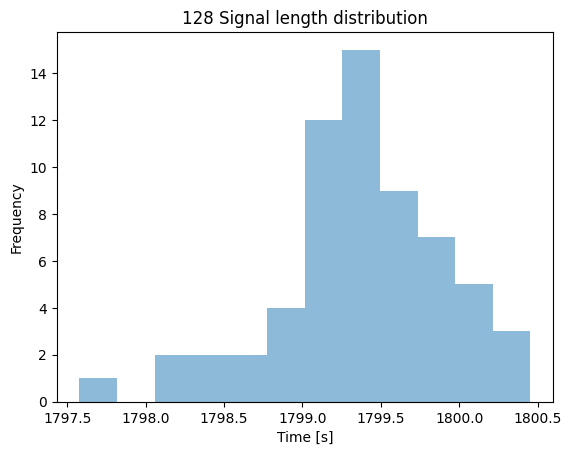

In [8]:
"Plot signal length distribution"
import pandas as pd
fs = 128  # To complete
# Create empty list to contain the different recording lenghts
length_recordings = list()

# Iterate through the different signals stored in "recordings": store signal
# length in senconds.
#We can derive the length by len[]/f
for rec_temp in ppgs_128:
    length_recordings.append(len(rec_temp) / fs)  # To Complete

# Transform to pandas series and plot histogram.
length_rec_s = pd.Series(length_recordings)
ax = length_rec_s.plot.hist(bins=12, alpha=0.5)
ax.set_xlabel("Time [s]")
ax.set_title("128 Signal length distribution")


In [9]:
#Take the first ppg 128 as sample for the next examples
signal_temp = ppgs_128[0]

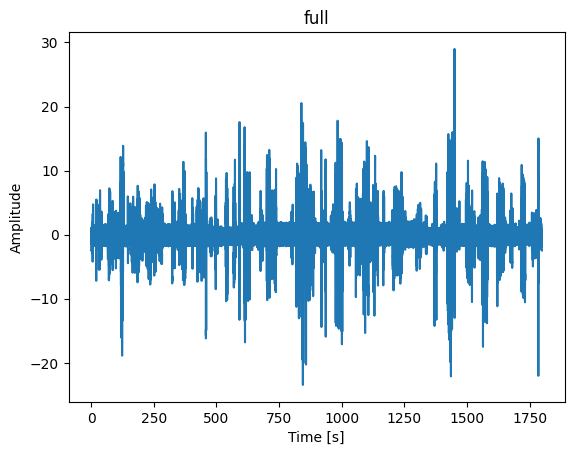

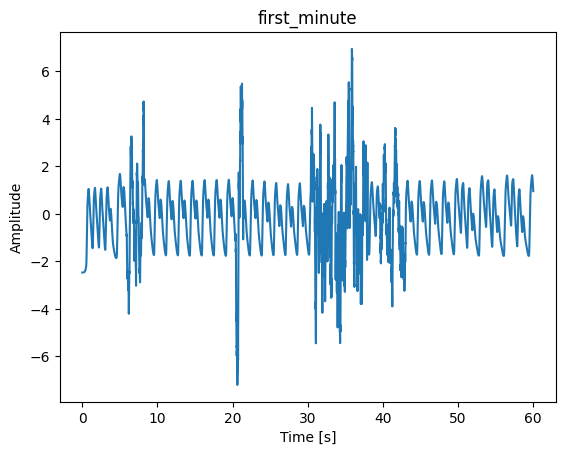

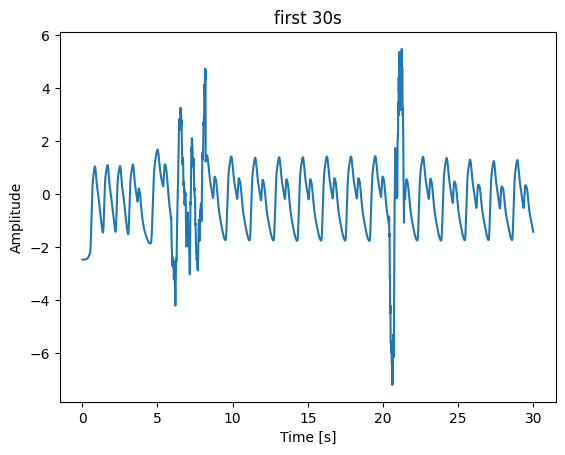

In [10]:
import matplotlib.pyplot as plt
lead = 0

#Plot 1 sample
t = np.arange(0, signal_temp.shape[0]/fs, 1/fs)
plot_signal(t, signal_temp, 'C0', 'full')

#Plot only the first minute 
signal_temp_reduced = signal_temp[:(128*60)]
t2 = np.arange(0, signal_temp_reduced.shape[0]/fs, 1/fs) 
plot_signal(t2, signal_temp_reduced, 'C0', 'first_minute')

#Plot only the first 30 seconds 
signal_temp_reduced_2 = signal_temp[:(128*30)]
t3 = np.arange(0, signal_temp_reduced_2.shape[0]/fs, 1/fs) 
plot_signal(t3, signal_temp_reduced_2, 'C0', 'first 30s')

#Possiamo apprezzare un disturbo sui 30 secondi

# Pre-processing

In [11]:
# Denoising --> second-order Butterworth filter

signal_temp_unidimensional = np.ravel(signal_temp)
#Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.
b, a = scipy.signal.butter(2, [0.5, 8], btype='bandpass', analog=False, output='ba', fs=128)

filtered_ppg = scipy.signal.filtfilt(b, a, signal_temp_unidimensional)

# Detrend
filtered_ppg = scipy.signal.detrend(filtered_ppg, axis=-1, type='linear', bp=0, overwrite_data=True)
filtered_ppg.shape

(230311,)

In [12]:
print(signal_temp)

[[-2.469272  ]
 [-2.46922243]
 [-2.46916616]
 ...
 [-2.46957188]
 [-2.46957329]
 [-2.46957465]]


In [13]:
print(filtered_ppg)

[-0.13845463 -0.14794415 -0.15766042 ...  0.02986455  0.02777053
  0.02562602]


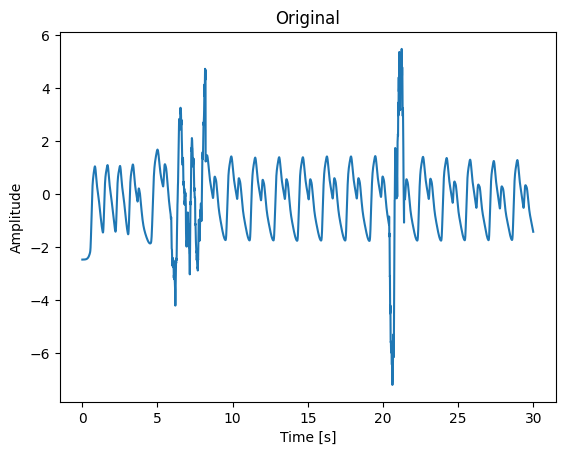

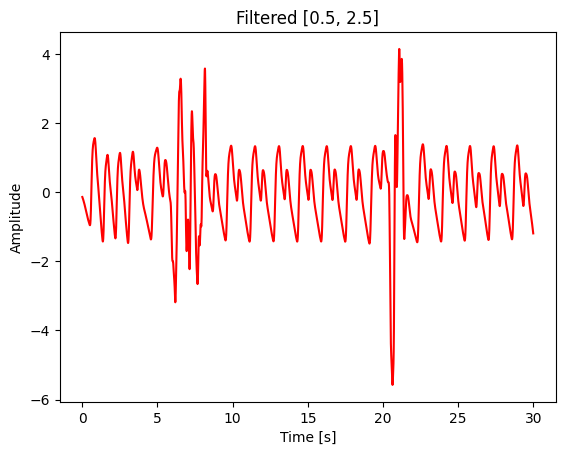

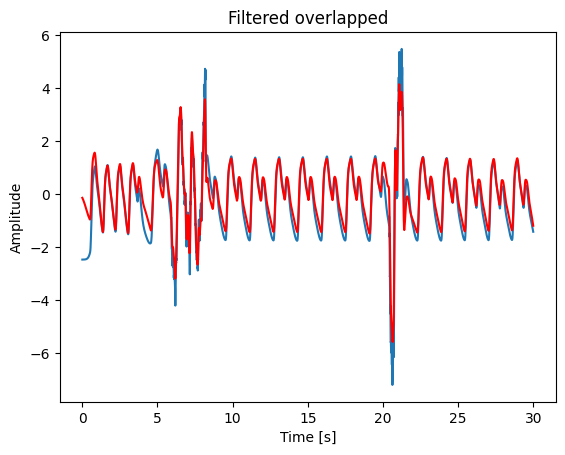

In [14]:
#Plot only the first 30 seconds 
signal_temp_reduced = signal_temp[:(128*30)]
t3 = np.arange(0, signal_temp_reduced.shape[0]/fs, 1/fs) 
plot_signal(t3, signal_temp_reduced, 'C0', 'Original')

#Plot only the first 30 seconds of the preprocessed
filt_red = filtered_ppg[:(128*30)]
t3 = np.arange(0, filt_red.shape[0]/fs, 1/fs)
plot_signal(t3, filt_red, 'r', 'Filtered [0.5, 2.5]')

#Filtered over original
#Plot only the first 30 seconds of the preprocessed
fig3, axs = plt.subplots()
axs.set_title("Filtered overlapped")
axs.plot(t3, signal_temp_reduced, color='C0')
axs.plot(t3, filt_red, color='r')
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.show()


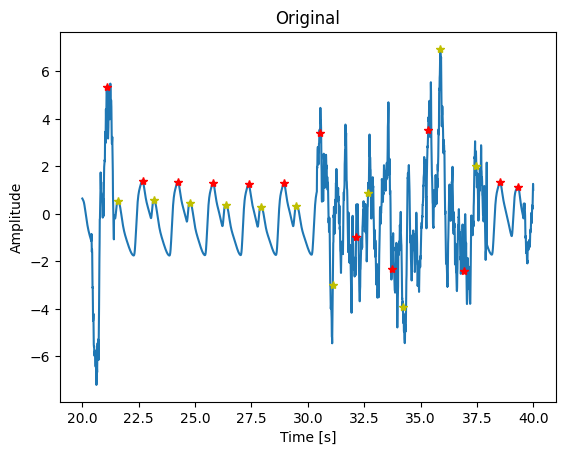

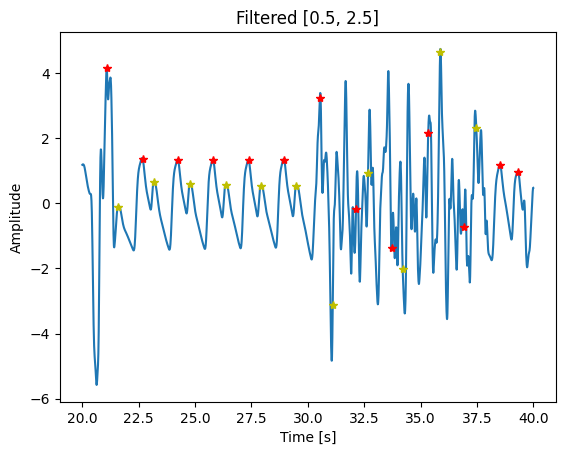

In [15]:
#Plot peaks positions

starting_time = 20
end_time = 40
time = np.arange(starting_time, end_time, 1/fs) # strat from 0 until the end of the signal_temp, with points distant by period 1/fs


fig, axs = plt.subplots()
#axs.set_title("Patient:" + str(patient) + " - Label:" + labels_adapt[patient])
axs.plot(time, signal_temp[(128*starting_time):(128*end_time)], color='C0')

i = 0
peak_pos = speaks_128[0][0]
components_out_of_interval = (128*starting_time)-1

for ann in annotations_128[0]:
    if(peak_pos >= components_out_of_interval+1 and peak_pos <= (128*end_time)):
        match ann:
            case 'N':
                axs.plot(time[peak_pos - components_out_of_interval],signal_temp[peak_pos],'*',color='r')
               
            case 'S':
                axs.plot(time[peak_pos - components_out_of_interval],signal_temp[peak_pos],'*',color='g')
                
            case 'V':
                axs.plot(time[peak_pos - components_out_of_interval],signal_temp[peak_pos],'*',color='y')
    i += 1
    if(i< len(annotations_128[0])):
        peak_pos = speaks_128[0][i]
    
#axs.plot(peakS/fs,signal_temp[0:20*128][posS],'*',color='r')
#axs.plot(peakV/fs,signal_temp[0:20*128][posV],'*',color='y')
axs.set_title("Original")
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.show()

#############################################################################################################

fig, axs = plt.subplots()
#axs.set_title("Patient:" + str(patient) + " - Label:" + labels_adapt[patient])
axs.plot(time, filtered_ppg[(128*starting_time):(128*end_time)], color='C0')

i = 0
peak_pos = speaks_128[0][0]
components_out_of_interval = (128*starting_time)-1

for ann in annotations_128[0]:
    if(peak_pos >= components_out_of_interval+1 and peak_pos <= (128*end_time)):
        match ann:
            case 'N':
                axs.plot(time[peak_pos - components_out_of_interval],filtered_ppg[peak_pos],'*',color='r')
               
            case 'S':
                axs.plot(time[peak_pos - components_out_of_interval],filtered_ppg[peak_pos],'*',color='g')
                
            case 'V':
                axs.plot(time[peak_pos - components_out_of_interval],filtered_ppg[peak_pos],'*',color='y')
    i += 1
    if(i< len(annotations_128[0])):
        peak_pos = speaks_128[0][i]
    
axs.set_title("Filtered [0.5, 2.5]")
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.show()


In [16]:
N=0
S=0
V=0
for i in range(len(annotations_128)):
    n=np.count_nonzero(annotations_128[i]=='N')
    s=np.count_nonzero(annotations_128[i]=='S')
    v=np.count_nonzero(annotations_128[i]=='V')
    N = N + n
    S = S + s
    V = V + v
for i in range(len(annotations_250)):
    n=np.count_nonzero(annotations_250[i]=='N')
    s=np.count_nonzero(annotations_250[i]=='S')
    v=np.count_nonzero(annotations_250[i]=='V')
    N = N + n
    S = S + s
    V = V + v
    
print(N,V,S)

228929 7994 9691


In [17]:
N=0
S=0
V=0
for i in range(len(annotations_250)):
    n=np.count_nonzero(annotations_250[i]=='N')
    s=np.count_nonzero(annotations_250[i]=='S')
    v=np.count_nonzero(annotations_250[i]=='V')
    N = N + n
    S = S + s
    V = V + v
    
print(N,V,S)

97101 389 863


# Extract fiducials

In [18]:
from dotmap import DotMap
sig = DotMap()
sig.filt_sig=filtered_ppg
sig.v=filtered_ppg
sig.filt_d1=filtered_ppg
sig.filt_d2=filtered_ppg
sig.filt_d3=filtered_ppg
sig.fs=128
sig.ppg

DotMap(_ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

In [19]:
from pyPPG import PPG, Fiducials, Biomarkers
import pyPPG.fiducials as FP

a = PPG(s=sig)
fpex = FP.FpCollection(s=a)
fiducials = fpex.get_fiducials(s=a)

fiducials

,on,sp,dn,dp,u,v,w,a,b,c,d,e,f,p1,p2
0,0,105,125,<NA>,105,113,<NA>,102,<NA>,<NA>,<NA>,<NA>,<NA>,104,<NA>
1,175,215,233,<NA>,215,242,<NA>,212,<NA>,<NA>,<NA>,<NA>,<NA>,214,<NA>
2,281,321,339,<NA>,321,350,<NA>,318,<NA>,<NA>,<NA>,<NA>,<NA>,320,<NA>
3,389,431,468,484,431,468,<NA>,428,467,467,467,483,482,483,467
4,584,637,661,<NA>,637,648,<NA>,634,<NA>,<NA>,<NA>,<NA>,<NA>,636,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874,229137,229184,229227,<NA>,229184,229215,229233,229181,229228,229233,229236,229253,229252,229233,229236
1875,229259,229293,229302,229310,229293,229302,229310,229290,229301,229301,229301,229309,229339,229309,229301
1876,229371,229409,229444,229446,229409,229442,229445,229406,229443,229442,229442,229445,229456,229445,229443
1877,229482,229530,229545,<NA>,229530,229551,229580,229502,229504,229529,229572,229580,229579,229529,229572


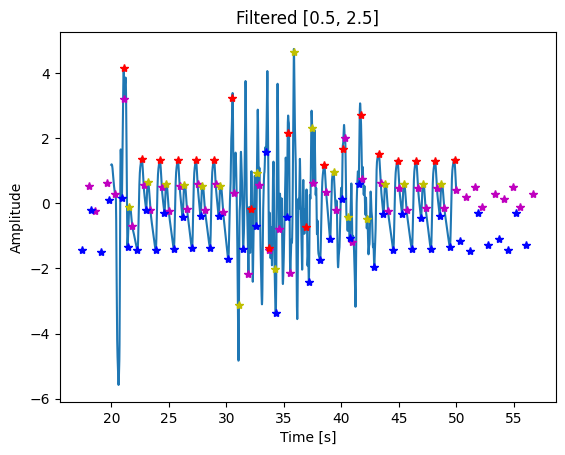

In [20]:
starting_time = 20
end_time = 50
time = np.arange(starting_time, end_time, 1/fs) 
fig, axs = plt.subplots()
#axs.set_title("Patient:" + str(patient) + " - Label:" + labels_adapt[patient])
axs.plot(time, filtered_ppg[(128*starting_time):(128*end_time)], color='C0')

i = 20
peak_pos = speaks_128[0][0]
components_out_of_interval = (128*starting_time)-1

for ann in annotations_128[0][0:45]:
    if(peak_pos >= components_out_of_interval+1 and peak_pos <= (128*end_time)):
        match ann:
            case 'N':
                axs.plot(time[peak_pos - components_out_of_interval],filtered_ppg[peak_pos],'*',color='r')
            
               
            case 'S':
                axs.plot(time[peak_pos - components_out_of_interval],filtered_ppg[peak_pos],'*',color='g')
                
            case 'V':
                axs.plot(time[peak_pos - components_out_of_interval],filtered_ppg[peak_pos],'*',color='y')
    
    axs.plot(fiducials['dn'].iloc[i]/fs,filtered_ppg[fiducials['dn'].iloc[i]],'*',color='m')
    axs.plot(fiducials['on'].iloc[i]/fs,filtered_ppg[fiducials['on'].iloc[i]],'*',color='b')
    i += 1      
    
    if(i< len(annotations_128[0])):
        peak_pos = speaks_128[0][i]
        

axs.set_title("Filtered [0.5, 2.5]")
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.show()

In [21]:
def check_speak(speak,signal):
    temp=speak
    prec=speak-1
    post=speak+1
    if(signal[temp]<signal[post] and signal[temp]>signal[prec]):
        while (signal[temp]<signal[post]):
            temp=post
            post+=1
    elif(signal[temp]>signal[post] and signal[temp]<signal[prec]):
        while (signal[temp]<signal[prec]):
            temp=prec
            prec-=1
            
    return temp

speaks_check = []
for i in range(len(speaks_128[0])):
    speaks_check.append(int(check_speak(speaks_128[0][i],filtered_ppg)[0]))
       

In [22]:
def find_on(peaks,fiducials):
    on=[]
    for p in range(len(peaks)):
        arr=[]
        arr=fiducials['on'].loc[fiducials['sp']>np.squeeze(peaks[p])-5]
        if(isinstance(np.squeeze(arr[0:1]), np.int64)):
            on.append(np.squeeze(arr[0:1]))
        else:
            on.append(np.nan)
    return on 

on = find_on(speaks_check,fiducials)


In [23]:
def find_dn(peaks,fiducials):
    dn=[]
    for p in range(len(peaks)):
        arr=[]
        arr=fiducials['dn'].loc[fiducials['sp']>np.squeeze(speaks_check[p])-5]
        if(isinstance(np.squeeze(arr[0:1]), np.int64)):
            dn.append(np.squeeze(arr[0:1]))
        else:
            dn.append(np.nan)
        
    return dn 

dn = find_dn(speaks_check,fiducials)

In [24]:
'''
starting_time = 0
end_time = 20
time = np.arange(starting_time, end_time, 1/fs) # strat from 0 until the end of the signal_temp, with points distant by period 1/fs


fig, axs = plt.subplots()
#axs.set_title("Patient:" + str(patient) + " - Label:" + labels_adapt[patient])
axs.plot(time, filtered_ppg[(128*starting_time):(128*end_time)], color='C0')

i = 0
peak = speaks_check[0]
o=on[0]
d=dn[0]

components_out_of_interval = (128*starting_time)-1

for ann in annotations_128[0]:
    if(peak >= components_out_of_interval+1 and peak <= (128*end_time)):
        match ann:
            case 'N':
                axs.plot(time[peak - components_out_of_interval],filtered_ppg[peak],'*',color='r')
                #axs.plot(time[o-components_out_of_interval],filtered_ppg[o],'*',color='m') 
                
               
            case 'S':
                axs.plot(time[peak - components_out_of_interval],filtered_ppg[peak],'*',color='g')
                #axs.plot(time[o-components_out_of_interval],filtered_ppg[o],'*',color='m') 
                
                
            case 'V':
                axs.plot(time[peak - components_out_of_interval],filtered_ppg[peak],'*',color='y')
                #axs.plot(time[o-components_out_of_interval],filtered_ppg[o],'*',color='m') 
    
    axs.plot(time[o-components_out_of_interval],filtered_ppg[o],'*',color='m') 
    axs.plot(time[d-components_out_of_interval],filtered_ppg[d],'*',color='k') 
    i += 1
    if(i<len(annotations_128[0])):
        peak = speaks_check[i]
        o = on[i]
        d = dn[i]
        
    
    
#axs.plot(peakS/fs,signal_temp[0:20*128][posS],'*',color='r')
#axs.plot(peakV/fs,signal_temp[0:20*128][posV],'*',color='y')
axs.set_title("Original")
axs.set_xlabel("Time [s]")
axs.set_ylabel("Amplitude")
plt.show()
'''

'\nstarting_time = 0\nend_time = 20\ntime = np.arange(starting_time, end_time, 1/fs) # strat from 0 until the end of the signal_temp, with points distant by period 1/fs\n\n\nfig, axs = plt.subplots()\n#axs.set_title("Patient:" + str(patient) + " - Label:" + labels_adapt[patient])\naxs.plot(time, filtered_ppg[(128*starting_time):(128*end_time)], color=\'C0\')\n\ni = 0\npeak = speaks_check[0]\no=on[0]\nd=dn[0]\n\ncomponents_out_of_interval = (128*starting_time)-1\n\nfor ann in annotations_128[0]:\n    if(peak >= components_out_of_interval+1 and peak <= (128*end_time)):\n        match ann:\n            case \'N\':\n                axs.plot(time[peak - components_out_of_interval],filtered_ppg[peak],\'*\',color=\'r\')\n                #axs.plot(time[o-components_out_of_interval],filtered_ppg[o],\'*\',color=\'m\') \n                \n               \n            case \'S\':\n                axs.plot(time[peak - components_out_of_interval],filtered_ppg[peak],\'*\',color=\'g\')\n              

Features Extraction

In [25]:
df_features = pd.DataFrame({
        #Execute -1 because matlab start counting from 1
        'peak_pos': speaks_check,
        'onset' : on,
        'diastolic_notch' : dn
    })

print(df_features)

      peak_pos  onset  diastolic_notch
0          106    0.0            125.0
1          214  175.0            233.0
2          320  281.0            339.0
3          430  389.0            468.0
4          484  584.0            661.0
...        ...    ...              ...
2054    229637    NaN              NaN
2055    229755    NaN              NaN
2056    229853    NaN              NaN
2057    229969    NaN              NaN
2058    230077    NaN              NaN

[2059 rows x 3 columns]


In [26]:
peak_pos = df_features['peak_pos']
mask_onset = df_features['onset'].notnull()
mask_notch = df_features['diastolic_notch'].notnull()


df_features['asp'] = filtered_ppg[peak_pos]
df_features.loc[mask_onset, 'adp'] = filtered_ppg[df_features.loc[mask_onset, 'onset'].astype(int)]
df_features.loc[mask_notch, 'adn'] = filtered_ppg[df_features.loc[mask_notch, 'diastolic_notch'].astype(int)]

df_features['rp'] = df_features['adp']/df_features['asp']
df_features['d1'] = df_features['asp'] - df_features['adn']
df_features['d2'] = df_features['adp'] - df_features['adn']
df_features['rd'] = df_features['d1']/df_features['d2']
#AMSP TODO
df_features['rn'] = df_features['adn']/df_features['asp']


In [27]:
df_features

,peak_pos,onset,diastolic_notch,asp,adp,adn,rp,d1,d2,rd,rn
0,106,0.0,125.0,1.561413,-0.138455,0.607896,-0.088673,0.953517,-0.746350,-1.277573,0.389324
1,214,175.0,233.0,1.079729,-1.426457,0.340316,-1.321125,0.739414,-1.766773,-0.418511,0.315186
2,320,281.0,339.0,1.137139,-1.334728,0.377719,-1.173760,0.759420,-1.712448,-0.443471,0.332166
3,430,389.0,468.0,1.169300,-1.468966,0.061593,-1.256279,1.107707,-1.530559,-0.723727,0.052675
4,484,584.0,661.0,0.653568,-1.366803,0.434736,-2.091293,0.218832,-1.801539,-0.121470,0.665173
...,...,...,...,...,...,...,...,...,...,...,...
2054,229637,NaN,NaN,0.088354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2055,229755,NaN,NaN,1.173088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2056,229853,NaN,NaN,0.984940,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2057,229969,NaN,NaN,1.391809,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Find rows with at least one NaN value using np.isnan()
rows_with_nan = df_features[df_features.applymap(lambda x: np.isnan(x) if isinstance(x, (float, np.float64)) else False).any(axis=1)]



Amplitude features
- ASP: amplitude systolic peak 
- ADP: amplitude onset peak
- ADN: amplitude dycrotic notch
- RP: ADP/ASP --> augmentation index
- D1: ASP-ADN
- D2: ADP-ADN
- RD: D1/D2
- AMSP: amplitude max slope point (massimo derivata prima)
- RN: ADN/ASP
Time-related feature
- TP: time interval from DP to SP
- T1: time interval from DN to SP
- T2: time interval from DP to DN
- pi2pi_pr: time interval from SPi-1 to SPi
- pi2pi_po time interval from SPi to SPi+1
- ST: 1/TP --> stiffness of large arteries
Area-related feature
- Area: area between 2 systolic peaks

In [29]:
df_features['T1'] = df_features['diastolic_notch']/128 - df_features['peak_pos']/128
df_features['T2'] = df_features['diastolic_notch']/128 - df_features['onset']/128
df_features['TP'] = df_features['peak_pos']/128 - df_features['onset']/128
df_features['ST'] = 1/df_features['TP']

# defining pi2pi_pr: time interval from SPi-1 to SPi
pi2pi_pr = []
# Add a first None value to align the dimension of the array
pi2pi_pr.append(np.nan)
for i in range(1, len(df_features)):
    val = df_features.loc[i]['peak_pos'] / fs - df_features.loc[i - 1]['peak_pos'] / fs
    pi2pi_pr.append(val)

pi2pi_pr = np.array(pi2pi_pr)
df_features['pi2pi_pr'] = pi2pi_pr


# pi2pi_po time interval from SPi to SPi+1
pi2pi_po = []
for i in range(len(df_features) - 1):
    val = df_features.loc[i + 1]['peak_pos'] / fs - df_features.loc[i]['peak_pos']/ fs
    pi2pi_po.append(val)


# Add a last None value to align the dimension of the array
pi2pi_po.append(np.nan)
pi2pi_po = np.array(pi2pi_po)
df_features['pi2pi_po'] = pi2pi_po

In [30]:
df_features

,peak_pos,onset,diastolic_notch,asp,adp,adn,rp,d1,d2,rd,rn,T1,T2,TP,ST,pi2pi_pr,pi2pi_po
0,106,0.0,125.0,1.561413,-0.138455,0.607896,-0.088673,0.953517,-0.746350,-1.277573,0.389324,0.148438,0.976562,0.828125,1.207547,NaN,0.843750
1,214,175.0,233.0,1.079729,-1.426457,0.340316,-1.321125,0.739414,-1.766773,-0.418511,0.315186,0.148438,0.453125,0.304688,3.282051,0.843750,0.828125
2,320,281.0,339.0,1.137139,-1.334728,0.377719,-1.173760,0.759420,-1.712448,-0.443471,0.332166,0.148438,0.453125,0.304688,3.282051,0.828125,0.859375
3,430,389.0,468.0,1.169300,-1.468966,0.061593,-1.256279,1.107707,-1.530559,-0.723727,0.052675,0.296875,0.617188,0.320312,3.121951,0.859375,0.421875
4,484,584.0,661.0,0.653568,-1.366803,0.434736,-2.091293,0.218832,-1.801539,-0.121470,0.665173,1.382812,0.601562,-0.781250,-1.280000,0.421875,1.210938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,229637,NaN,NaN,0.088354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.843750,0.921875
2055,229755,NaN,NaN,1.173088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.921875,0.765625
2056,229853,NaN,NaN,0.984940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.765625,0.906250
2057,229969,NaN,NaN,1.391809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.906250,0.843750


In [32]:
# Remove rows with NaN values
df_cleaned = df_features.drop(['peak_pos', 'onset', 'diastolic_notch'], axis=1)

df_cleaned = df_cleaned.drop(rows_with_nan.index)
df_cleaned = df_cleaned.dropna()
df_cleaned

,asp,adp,adn,rp,d1,d2,rd,rn,T1,T2,TP,ST,pi2pi_pr,pi2pi_po
1,1.079729,-1.426457,0.340316,-1.321125,0.739414,-1.766773,-0.418511,0.315186,0.148438,0.453125,0.304688,3.282051,0.843750,0.828125
2,1.137139,-1.334728,0.377719,-1.173760,0.759420,-1.712448,-0.443471,0.332166,0.148438,0.453125,0.304688,3.282051,0.828125,0.859375
3,1.169300,-1.468966,0.061593,-1.256279,1.107707,-1.530559,-0.723727,0.052675,0.296875,0.617188,0.320312,3.121951,0.859375,0.421875
4,0.653568,-1.366803,0.434736,-2.091293,0.218832,-1.801539,-0.121470,0.665173,1.382812,0.601562,-0.781250,-1.280000,0.421875,1.210938
5,1.282122,-1.366803,0.434736,-1.066047,0.847386,-1.801539,-0.470368,0.339075,0.171875,0.601562,0.429688,2.327273,1.210938,0.523438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,1.227715,-1.390692,-0.965626,-1.132748,2.193341,-0.425066,-5.160005,-0.786523,0.289062,0.617188,0.328125,3.047619,0.890625,0.914062
2050,2.310058,-2.154876,-1.751811,-0.932823,4.061869,-0.403065,-10.077442,-0.758341,0.328125,0.703125,0.375000,2.666667,0.914062,0.867188
2051,0.737038,-0.625223,0.606941,-0.848292,0.130097,-1.232164,-0.105584,0.823487,0.046875,0.335938,0.289062,3.459459,0.867188,0.890625
2052,1.459671,-1.290165,-0.487602,-0.883874,1.947273,-0.802563,-2.426319,-0.334049,0.265625,0.570312,0.304688,3.282051,0.890625,0.929688


In [33]:
#Compact signals 128 info in a unique dataframe
signals_128_dataframes = []

for i in range(len(ppgs_128)):
    df_annotations = pd.DataFrame({
        #Execute -1 because matlab start counting from 1
        'peak_pos': np.ravel(speaks_128[i]) -1,
        'peak_nature': np.ravel(annotations_128[i])
    })
    
    df_values = pd.DataFrame({
        'PPG_Value': np.ravel(ppgs_128[i]),
    })
    
    # Merge DataFrames based on row positions
    merged_df = pd.merge(df_values, df_annotations, left_index=True, right_on='peak_pos', how='left')
    
    #Set isPeak true if that pos is a peak
    merged_df['isPeak'] = ~merged_df['peak_nature'].isnull()
    
    # Drop the 'peak_pos' column
    merged_df.drop(columns=['peak_pos'], inplace=True)
    
    # Reorder columns to have 'isPeak' in the second position
    merged_df = merged_df[['PPG_Value', 'isPeak', 'peak_nature']]
    
    # Reset index
    merged_df.reset_index(drop=True, inplace=True)
    signals_128_dataframes.append(merged_df)


In [34]:
#Compact signals 250 info in a unique dataframe
signals_250_dataframes = []

for i in range(len(ppgs_250)):
    df_annotations = pd.DataFrame({
        #Execute -1 because matlab start counting from 1
        'peak_pos': np.ravel(speaks_250[i]) -1,
        'peak_nature': np.ravel(annotations_250[i])
    })
    
    df_values = pd.DataFrame({
        'PPG_Value': np.ravel(ppgs_250[i]),
    })
    
    # Merge DataFrames based on row positions
    merged_df = pd.merge(df_values, df_annotations, left_index=True, right_on='peak_pos', how='left')
    
    #Set isPeak true if that pos is a peak
    merged_df['isPeak'] = ~merged_df['peak_nature'].isnull()
    
    # Drop the 'peak_pos' column
    merged_df.drop(columns=['peak_pos'], inplace=True)
    
    # Reorder columns to have 'isPeak' in the second position
    merged_df = merged_df[['PPG_Value', 'isPeak', 'peak_nature']]
    
    # Reset index
    merged_df.reset_index(drop=True, inplace=True)
    signals_250_dataframes.append(merged_df)


In [35]:
print(len(signals_128_dataframes))
signals_128_dataframes[0]

62


,PPG_Value,isPeak,peak_nature
0,-2.469272,False,NaN
1,-2.469222,False,NaN
2,-2.469166,False,NaN
3,-2.469102,False,NaN
4,-2.469030,False,NaN
...,...,...,...
230306,-2.469569,False,NaN
230307,-2.469570,False,NaN
230308,-2.469572,False,NaN
230309,-2.469573,False,NaN


In [36]:
print(len(signals_250_dataframes))
#signals_250_dataframe

43


In [37]:
for i in range(len(speaks_128)):
    peals = len(signals_128_dataframes[i].loc[signals_128_dataframes[i]['isPeak']==True])
    print(i,peals/((len(signals_128_dataframes[i])/128)/60),peals, (len(signals_128_dataframes[i])/128)/60)
#for i in range(len(signals_128_dataframes)):
    #print(len(signals_128_dataframes[i])/128)

0 68.65985558657641 2059 29.988411458333335
1 93.15615425342627 2795 30.003385416666667
2 55.94280281818537 1678 29.994921875
3 99.93817082913613 2997 29.988541666666666
4 71.3177405694182 2138 29.978515625
5 104.06314308786371 3121 29.99140625
6 63.37073967272349 1900 29.982291666666665
7 80.57075117350506 2416 29.986067708333334
8 78.17506741880432 2344 29.983984375
9 71.96488043803924 2158 29.986848958333333
10 87.51557351785691 2625 29.994661458333333
11 62.751097396670865 1880 29.959635416666668
12 62.00165023667868 1859 29.983072916666668
13 88.8094524705913 2663 29.985546875
14 105.33886199335691 3159 29.988932291666668
15 72.87160357653109 2185 29.984244791666665
16 72.60290509585947 2177 29.985026041666668
17 84.1743388069225 2525 29.997265625
18 79.45609419364922 2383 29.99140625
19 85.2284834775511 2556 29.989973958333334
20 86.03295992638921 2581 30.000130208333335
21 63.61518591677701 1908 29.992838541666668
22 90.14397417316822 2705 30.007552083333334
23 88.65348452408354

Text(0.5, 1.0, 'Freq')

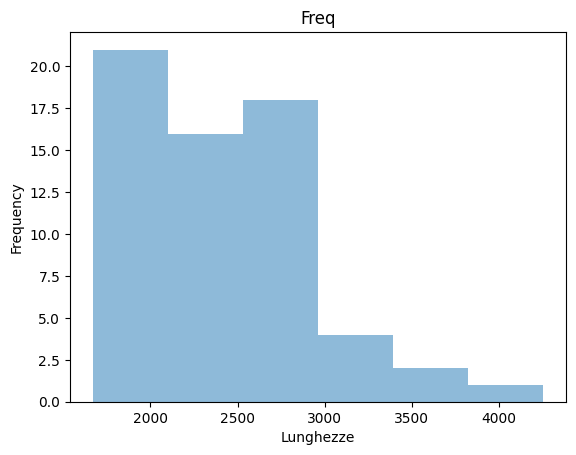

In [38]:
lunghezze = []
for i in range(len(speaks_128)):
    peals = len(signals_128_dataframes[i].loc[signals_128_dataframes[i]['isPeak']==True])
    lunghezze.append(peals)
lengths = pd.Series(lunghezze)
ax = lengths.plot.hist(bins=6, alpha=0.5)
ax.set_xlabel("Lunghezze")
ax.set_title("Freq")

Text(0.5, 1.0, 'BPM')

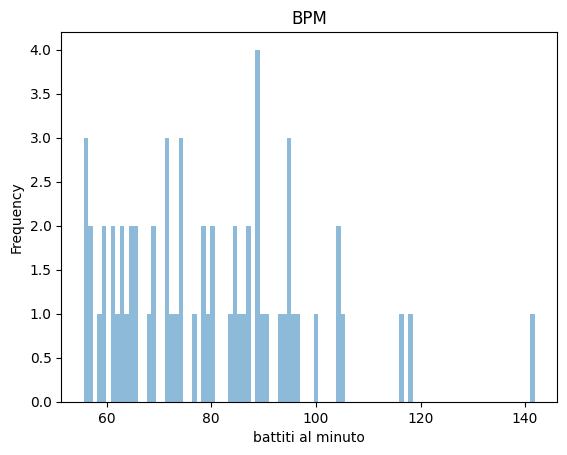

In [39]:
bpm = []
for i in range(len(speaks_128)):
    peals = len(signals_128_dataframes[i].loc[signals_128_dataframes[i]['isPeak']==True])
    beats = peals/((len(signals_128_dataframes[i])/128)/60)
    bpm.append(beats)
battiti = pd.Series(bpm)
ax = battiti.plot.hist(bins=100, alpha=0.5)
ax.set_xlabel("battiti al minuto")
ax.set_title("BPM")

In [ ]:
a=signals_128_dataframes[34]['peak_nature'].loc[signals_128_dataframes[34]['isPeak']==True]
a.value_counts()

In [40]:
from pyPPG import PPG, Fiducials, Biomarkers
import pyPPG.fiducials as FP
from dotmap import DotMap

def CreateDataSet_128(signal_dataframe):
    peak_nature = signal_dataframe['peak_nature']
    labels = peak_nature.dropna()
    speaks_temp = (signal_dataframe.loc[signal_dataframe['isPeak']==True].index.values + 1)
    #print(len(speaks_temp))
    signal_temp = signal_dataframe['PPG_Value']
    signal_temp_unidimensional = np.ravel(signal_temp)
    #Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.
    b, a = scipy.signal.butter(2, [0.5, 8], btype='bandpass', analog=False, output='ba', fs=128)
    filtered_ppg = scipy.signal.filtfilt(b, a, signal_temp_unidimensional)
    # Detrend
    filtered_ppg = scipy.signal.detrend(filtered_ppg, axis=-1, type='linear', bp=0, overwrite_data=True)
    
    sig = DotMap()
    sig.filt_sig=filtered_ppg
    sig.v=filtered_ppg
    sig.filt_d1=filtered_ppg
    sig.filt_d2=filtered_ppg
    sig.filt_d3=filtered_ppg
    sig.fs=128
    sig.ppg

    a = PPG(s=sig)
    fpex = FP.FpCollection(s=a)
    fiducials = fpex.get_fiducials(s=a)
    
    def check_speak(speak,signal):
        temp=speak
        prec=speak-1
        post=speak+1
        if(signal[temp]<signal[post] and signal[temp]>signal[prec]):
            while (signal[temp]<signal[post]):
                temp=post
                post+=1
        elif(signal[temp]>signal[post] and signal[temp]<signal[prec]):
            while (signal[temp]<signal[prec]):
                temp=prec
                prec-=1

        return temp

    speaks_check = []
    for i in range(len(speaks_temp)):
        speaks_check.append(int(check_speak(speaks_temp[i],filtered_ppg)))
        
    def find_on(peaks,fiducials):
        on=[]
        for p in range(len(peaks)):
            arr=[]
            arr=fiducials['on'].loc[fiducials['sp']>np.squeeze(peaks[p])-5]
            if(isinstance(np.squeeze(arr[0:1]), np.int64)):
                on.append(np.squeeze(arr[0:1]))
            else:
                on.append(np.nan)
        return on 

    on = find_on(speaks_check,fiducials)
    
    def find_dn(peaks,fiducials):
        dn=[]
        for p in range(len(peaks)):
            arr=[]
            arr=fiducials['dn'].loc[fiducials['sp']>np.squeeze(speaks_check[p])-5]
            if(isinstance(np.squeeze(arr[0:1]), np.int64)):
                dn.append(np.squeeze(arr[0:1]))
            else:
                dn.append(np.nan)

        return dn 

    dn = find_dn(speaks_check,fiducials)
    #print(len(speaks_check), len(on), len(dn), len(labels))
    df_features = pd.DataFrame({
        #Execute -1 because matlab start counting from 1
        'peak_pos': speaks_check,
        'onset' : on,
        'diastolic_notch' : dn,
        'label': labels,
    })
    
    peak_pos = df_features['peak_pos']
    mask_onset = df_features['onset'].notnull()
    mask_notch = df_features['diastolic_notch'].notnull()


    df_features['asp'] = filtered_ppg[peak_pos]
    df_features.loc[mask_onset, 'adp'] = filtered_ppg[df_features.loc[mask_onset, 'onset'].astype(int)]
    df_features.loc[mask_notch, 'adn'] = filtered_ppg[df_features.loc[mask_notch, 'diastolic_notch'].astype(int)]

    df_features['rp'] = df_features['adp']/df_features['asp']
    df_features['d1'] = df_features['asp'] - df_features['adn']
    df_features['d2'] = df_features['adp'] - df_features['adn']
    df_features['rd'] = df_features['d1']/df_features['d2']
    #AMSP TODO
    df_features['rn'] = df_features['adn']/df_features['asp']
    
    df_features['T1'] = df_features['diastolic_notch']/128 - df_features['peak_pos']/128
    df_features['T2'] = df_features['diastolic_notch']/128 - df_features['onset']/128
    df_features['TP'] = df_features['peak_pos']/128 - df_features['onset']/128
    df_features['ST'] = 1/df_features['TP']

    # defining pi2pi_pr: time interval from SPi-1 to SPi
    pi2pi_pr = []
    # Add a first None value to align the dimension of the array
    pi2pi_pr.append(np.nan)
    for i in range(1, len(df_features)):
        val = df_features.iloc[i]['peak_pos'] / fs - df_features.iloc[i - 1]['peak_pos'] / fs
        pi2pi_pr.append(val)

    pi2pi_pr = np.array(pi2pi_pr)
    df_features['pi2pi_pr'] = pi2pi_pr


    # pi2pi_po time interval from SPi to SPi+1
    pi2pi_po = []
    for i in range(len(df_features) - 1):
        val = df_features.iloc[i + 1]['peak_pos'] / fs - df_features.iloc[i]['peak_pos']/ fs
        pi2pi_po.append(val)


    # Add a last None value to align the dimension of the array
    pi2pi_po.append(np.nan)
    pi2pi_po = np.array(pi2pi_po)
    df_features['pi2pi_po'] = pi2pi_po
    
    df_NoNan=df_features.dropna()
    print('completing')
    return df_NoNan 
 
    

In [41]:
from pyPPG import PPG, Fiducials, Biomarkers
import pyPPG.fiducials as FP
from dotmap import DotMap

def CreateDataSet_250(signal_dataframe):
    peak_nature = signal_dataframe['peak_nature']
    labels = peak_nature.dropna()
    speaks_temp = (signal_dataframe.loc[signal_dataframe['isPeak']==True].index.values + 1)
    #print(len(speaks_temp))
    signal_temp = signal_dataframe['PPG_Value']
    signal_temp_unidimensional = np.ravel(signal_temp)
    #Let's run it through a standard butterworth bandpass implementation to remove everything < 0.8 and > 3.5 Hz.
    b, a = scipy.signal.butter(2, [0.5, 8], btype='bandpass', analog=False, output='ba', fs=250)
    filtered_ppg = scipy.signal.filtfilt(b, a, signal_temp_unidimensional)
    # Detrend
    filtered_ppg = scipy.signal.detrend(filtered_ppg, axis=-1, type='linear', bp=0, overwrite_data=True)
    
    sig = DotMap()
    sig.filt_sig=filtered_ppg
    sig.v=filtered_ppg
    sig.filt_d1=filtered_ppg
    sig.filt_d2=filtered_ppg
    sig.filt_d3=filtered_ppg
    sig.fs=250
    sig.ppg

    a = PPG(s=sig)
    fpex = FP.FpCollection(s=a)
    fiducials = fpex.get_fiducials(s=a)
    
    def check_speak(speak,signal):
        temp=speak
        prec=speak-1
        post=speak+1
        if(signal[temp]<signal[post] and signal[temp]>signal[prec]):
            while (signal[temp]<signal[post]):
                temp=post
                post+=1
        elif(signal[temp]>signal[post] and signal[temp]<signal[prec]):
            while (signal[temp]<signal[prec]):
                temp=prec
                prec-=1

        return temp

    speaks_check = []
    for i in range(len(speaks_temp)):
        speaks_check.append(int(check_speak(speaks_temp[i],filtered_ppg)))
        
    def find_on(peaks,fiducials):
        on=[]
        for p in range(len(peaks)):
            arr=[]
            arr=fiducials['on'].loc[fiducials['sp']>np.squeeze(peaks[p])-5]
            if(isinstance(np.squeeze(arr[0:1]), np.int64)):
                on.append(np.squeeze(arr[0:1]))
            else:
                on.append(np.nan)
        return on 

    on = find_on(speaks_check,fiducials)
    
    def find_dn(peaks,fiducials):
        dn=[]
        for p in range(len(peaks)):
            arr=[]
            arr=fiducials['dn'].loc[fiducials['sp']>np.squeeze(speaks_check[p])-5]
            if(isinstance(np.squeeze(arr[0:1]), np.int64)):
                dn.append(np.squeeze(arr[0:1]))
            else:
                dn.append(np.nan)

        return dn 

    dn = find_dn(speaks_check,fiducials)
    #print(len(speaks_check), len(on), len(dn), len(labels))
    df_features = pd.DataFrame({
        #Execute -1 because matlab start counting from 1
        'peak_pos': speaks_check,
        'onset' : on,
        'diastolic_notch' : dn,
        'label': labels,
    })
    
    peak_pos = df_features['peak_pos']
    mask_onset = df_features['onset'].notnull()
    mask_notch = df_features['diastolic_notch'].notnull()


    df_features['asp'] = filtered_ppg[peak_pos]
    df_features.loc[mask_onset, 'adp'] = filtered_ppg[df_features.loc[mask_onset, 'onset'].astype(int)]
    df_features.loc[mask_notch, 'adn'] = filtered_ppg[df_features.loc[mask_notch, 'diastolic_notch'].astype(int)]

    df_features['rp'] = df_features['adp']/df_features['asp']
    df_features['d1'] = df_features['asp'] - df_features['adn']
    df_features['d2'] = df_features['adp'] - df_features['adn']
    df_features['rd'] = df_features['d1']/df_features['d2']
    #AMSP TODO
    df_features['rn'] = df_features['adn']/df_features['asp']
    
    df_features['T1'] = df_features['diastolic_notch']/250 - df_features['peak_pos']/250
    df_features['T2'] = df_features['diastolic_notch']/250 - df_features['onset']/250
    df_features['TP'] = df_features['peak_pos']/250 - df_features['onset']/250
    df_features['ST'] = 1/df_features['TP']

    # defining pi2pi_pr: time interval from SPi-1 to SPi
    pi2pi_pr = []
    # Add a first None value to align the dimension of the array
    pi2pi_pr.append(np.nan)
    for i in range(1, len(df_features)):
        val = df_features.iloc[i]['peak_pos'] / fs - df_features.iloc[i - 1]['peak_pos'] / fs
        pi2pi_pr.append(val)

    pi2pi_pr = np.array(pi2pi_pr)
    df_features['pi2pi_pr'] = pi2pi_pr


    # pi2pi_po time interval from SPi to SPi+1
    pi2pi_po = []
    for i in range(len(df_features) - 1):
        val = df_features.iloc[i + 1]['peak_pos'] / fs - df_features.iloc[i]['peak_pos']/ fs
        pi2pi_po.append(val)


    # Add a last None value to align the dimension of the array
    pi2pi_po.append(np.nan)
    pi2pi_po = np.array(pi2pi_po)
    df_features['pi2pi_po'] = pi2pi_po
    
    df_NoNan=df_features.dropna()
    print('completing')
    return df_NoNan 
 
    

In [42]:
df_tot_128 = pd.DataFrame({
        #Execute -1 because matlab start counting from 1
        'peak_pos': [],
        'onset' : [],
        'diastolic_notch' : [],
        'asp': [],
        'adp': [],
        'rp' : [],
        'd1' : [],
        'd2': [],
        'rn': [],
        'T1': [],
        'T2' : [],
        'TP' : [],
        'ST': [],
        'pi2pi_pr': [],
        'pi2pi_po': [],
        'label': [],
    })
for i in range(len(signals_128_dataframes)):
    df = CreateDataSet_128(signals_128_dataframes[i])
    print(i)
    df_tot_128 = pd.concat([df_tot_128, df], ignore_index=True)
df_tot_128

completing
0
completing
1
completing
2
completing
3
completing
4
completing
5
completing
6
completing
7
completing
8
completing
9
completing
10
completing
11
completing
12
completing
13
completing
14
completing
15
completing
16
completing
17
completing
18
completing
19
completing
20
completing
21
completing
22
completing
23
completing
24
completing
25
completing
26
completing
27
completing
28
completing
29
completing
30
completing
31
completing
32
completing
33
completing
34
completing
35
completing
36
completing
37
completing
38
completing
39
completing
40
completing
41
completing
42
completing
43
completing
44
completing
45
completing
46
completing
47
completing
48
completing
49
completing
50
completing
51
completing
52
completing
53
completing
54
completing
55
completing
56
completing
57
completing
58
completing
59
completing
60
completing
61


,peak_pos,onset,diastolic_notch,asp,adp,rp,d1,d2,rn,T1,T2,TP,ST,pi2pi_pr,pi2pi_po,label,adn,rd
0,215.0,175.0,233.0,1.079736,-1.426457,-1.321117,0.739420,-1.766773,0.315184,0.140625,0.453125,0.312500,3.200000,0.859375,0.828125,N,0.340316,-0.418515
1,321.0,281.0,339.0,1.138052,-1.334728,-1.172818,0.760333,-1.712448,0.331900,0.140625,0.453125,0.312500,3.200000,0.828125,0.859375,N,0.377719,-0.444004
2,431.0,389.0,468.0,1.170092,-1.468966,-1.255428,1.108499,-1.530559,0.052639,0.289062,0.617188,0.328125,3.047619,0.859375,0.414062,N,0.061593,-0.724245
3,484.0,584.0,661.0,0.653568,-1.366803,-2.091293,0.218832,-1.801539,0.665173,1.382812,0.601562,-0.781250,-1.280000,0.414062,1.195312,V,0.434736,-0.121470
4,637.0,584.0,661.0,1.287407,-1.366803,-1.061671,0.852671,-1.801539,0.337683,0.187500,0.601562,0.414062,2.415094,1.195312,0.546875,N,0.434736,-0.473301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147774,228970.0,228926.0,229006.0,1.312881,-1.402964,-1.068615,1.171323,-1.544522,0.107822,0.281250,0.625000,0.343750,2.909091,1.054688,1.039062,N,0.141558,-0.758372
147775,229103.0,229060.0,229137.0,1.264467,-1.339628,-1.059440,1.095453,-1.508642,0.133664,0.265625,0.601562,0.335938,2.976744,1.039062,1.031250,N,0.169014,-0.726119
147776,229235.0,229192.0,229270.0,1.281071,-1.336991,-1.043651,1.112768,-1.505295,0.131377,0.273438,0.609375,0.335938,2.976744,1.031250,1.054688,N,0.168303,-0.739236
147777,229370.0,229327.0,229406.0,1.279507,-1.350105,-1.055176,1.176766,-1.452846,0.080297,0.281250,0.617188,0.335938,2.976744,1.054688,1.023438,N,0.102741,-0.809973


In [46]:
df_tot_250 = pd.DataFrame({
        #Execute -1 because matlab start counting from 1
        'peak_pos': [],
        'onset' : [],
        'diastolic_notch' : [],
        'asp': [],
        'adp': [],
        'rp' : [],
        'd1' : [],
        'd2': [],
        'rn': [],
        'T1': [],
        'T2' : [],
        'TP' : [],
        'ST': [],
        'pi2pi_pr': [],
        'pi2pi_po': [],
        'label': [],
    })
for i in range(len(signals_250_dataframes)):
    df = CreateDataSet_250(signals_250_dataframes[i])
    print(i)
    df_tot_250 = pd.concat([df_tot_250, df], ignore_index=True)
df_tot_250

completing
0
completing
1
completing
2
completing
3
completing
4
completing
5
completing
6
completing
7
completing
8
completing
9
completing
10
completing
11
completing
12
completing
13
completing
14
completing
15
completing
16
completing
17
completing
18
completing
19
completing
20
completing
21
completing
22
completing
23
completing
24
completing
25
completing
26
completing
27
completing
28
completing
29
completing
30
completing
31
completing
32
completing
33
completing
34
completing
35
completing
36
completing
37
completing
38
completing
39
completing
40
completing
41
completing
42


,peak_pos,onset,diastolic_notch,asp,adp,rp,d1,d2,rn,T1,T2,TP,ST,pi2pi_pr,pi2pi_po,label,adn,rd
0,576.0,491.0,592.0,11.171367,-37.344534,-3.342879,5.562800,-42.953101,0.502048,0.064,0.404,0.340,2.941176,2.500000,2.117188,N,5.608567,-0.129509
1,847.0,878.0,990.0,5.387103,-3.954062,-0.733987,51.520037,42.178873,-8.563589,0.572,0.448,-0.124,-8.064516,2.117188,1.945312,N,-46.132934,1.221465
2,1096.0,1044.0,1163.0,83.312135,-11.860349,-0.142360,131.754251,36.581767,-0.581453,0.268,0.476,0.208,4.807692,1.945312,2.492188,N,-48.442116,3.601637
3,1415.0,1466.0,1610.0,14.950293,-40.431212,-2.704376,-2.801427,-58.182932,1.187383,0.780,0.576,-0.204,-4.901961,2.492188,2.523438,N,17.751720,0.048149
4,1738.0,1676.0,1764.0,44.612642,-77.933769,-1.746899,40.507663,-82.038748,0.092014,0.104,0.352,0.248,4.032258,2.523438,1.929688,N,4.104979,-0.493763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97878,447234.0,447147.0,447295.0,27.776922,-40.943156,-1.473999,32.554691,-36.165387,-0.172005,0.244,0.592,0.348,2.873563,2.367188,1.054688,N,-4.777769,-0.900162
97879,447369.0,447409.0,447565.0,-19.279856,-32.720276,1.697122,22.037422,8.597002,2.143028,0.784,0.624,-0.160,-6.250000,1.054688,2.109375,N,-41.317278,2.563384
97880,447639.0,447679.0,447786.0,-18.637071,-31.693546,1.700565,-45.786612,-58.843087,-1.456749,0.588,0.428,-0.160,-6.250000,2.109375,0.953125,N,27.149541,0.778114
97881,447761.0,447679.0,447786.0,36.088528,-31.693546,-0.878217,8.938986,-58.843087,0.752304,0.100,0.428,0.328,3.048780,0.953125,2.820312,N,27.149541,-0.151912


In [48]:
print('Number of N 128: ', np.count_nonzero(df_tot_128['label'] == 'N'))
print('Number of N 250: ', np.count_nonzero(df_tot_250['label'] == 'N'))

print('Number of V 128: ', np.count_nonzero(df_tot_128['label'] == 'V'))
print('Number of V 250: ', np.count_nonzero(df_tot_250['label'] == 'V'))

print('Number of S 128: ', np.count_nonzero(df_tot_128['label'] == 'S'))
print('Number of S 250: ', np.count_nonzero(df_tot_250['label'] == 'S'))

Number of N 128:  131404
Number of N 250:  96638
Number of V 128:  7575
Number of V 250:  387
Number of S 128:  8800
Number of S 250:  858


In [51]:
#@title Set up the environment
import os
import numpy as np, os, sys, joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile

from scipy import optimize

from scipy.signal import butter, lfilter, filtfilt

from keras.utils import pad_sequences
import math

import tensorflow as tf
from tensorflow import keras

from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model

import random

import sklearn

#import keras.backend as K
#K.set_image_data_format('channels_last')

In [52]:
'''# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.efficientnet import preprocess_input
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)'''

NameError: name 'logging' is not defined

In [53]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [70]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [73]:
df_tot = pd.concat([df_tot_128,df_tot_250], axis = 0, ignore_index = True)
df_tot.replace([np.inf, -np.inf], np.nan, inplace=True)
df_tot.dropna(inplace=True)

X_train = df_tot.drop(['label'], axis=1)
Y_train = df_tot['label']

In [74]:
nN = np.count_nonzero(Y_train == 'N')
nV = np.count_nonzero(Y_train == 'V')
nS = np.count_nonzero(Y_train == 'S')

class_sum = nN+nV+nS
wN = round(1-(nN/class_sum),2)
wV = round(1-(nV/class_sum),2)  
wS = round(1-(nS/class_sum),2)

Y_train=pd.Series(Y_train).map({'N': 0, 'V': 1, 'S': 2})
class_weights = {0: wN, 1: wV, 2: wS}
print(class_weights)

{0: 0.07, 1: 0.97, 2: 0.96}


In [75]:
X_train, X_test, Y_train, y_test = train_test_split(X_train, Y_train, random_state = seed, test_size = .15, stratify = Y_train)


In [62]:
'''#Custom loss function
#output loss function is the sum
#epsilon to not have log0

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            
            loss += tf.keras.backend.mean(-(pos_weights[i] *y_true[:,i] * tf.keras.backend.log(y_pred[:,i] + epsilon)
                             + neg_weights[i]* (1 - y_true[:,i]) * tf.keras.backend.log( 1 - y_pred[:,i] + epsilon)))
        return loss
    return weighted_loss'''

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
# Models
models = {
   #'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest 2': RandomForestClassifier(n_estimators=100, 
                                              criterion='gini', 
                                              max_depth=15 ,
                                              min_samples_split=22, 
                                              class_weight=class_weights),
    'Balanced Random Forest': BalancedRandomForestClassifier(n_estimators=100, class_weight=class_weights),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

# Train and evaluate each model

NameError: name 'model_evaluation' is not defined

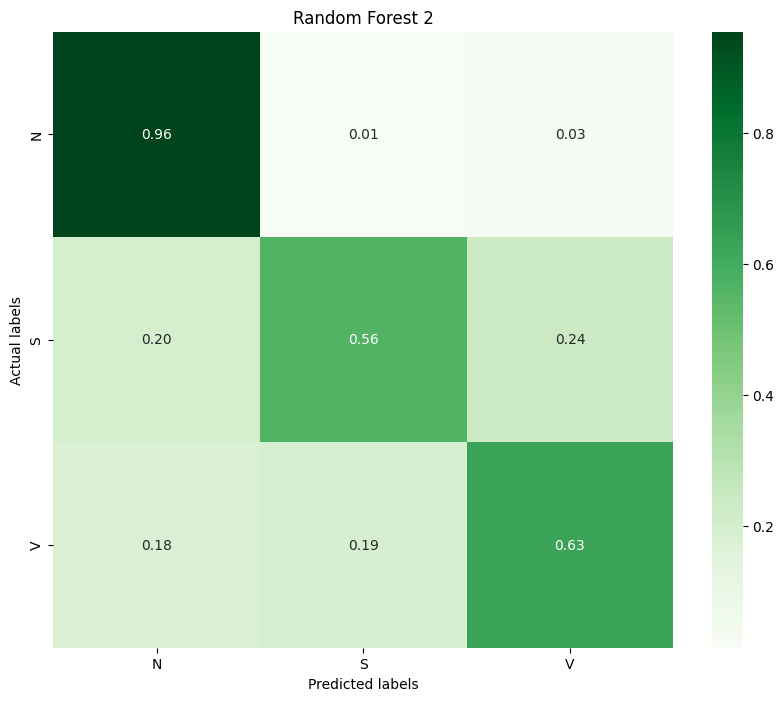

/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/conda/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


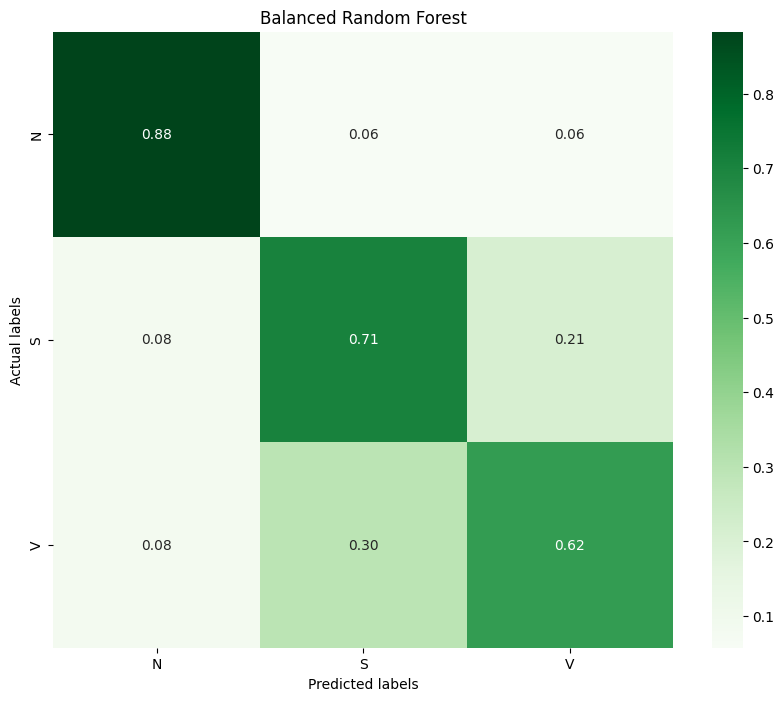

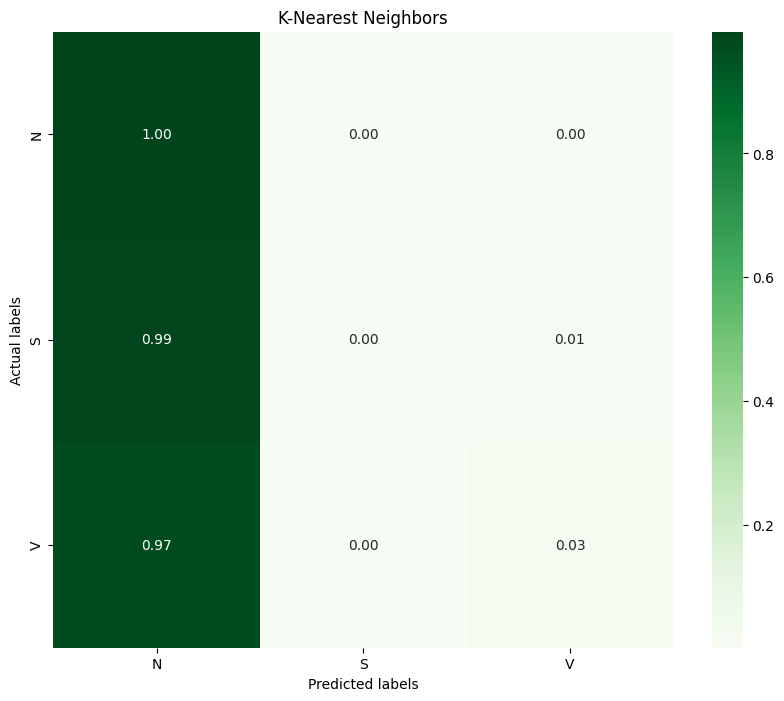

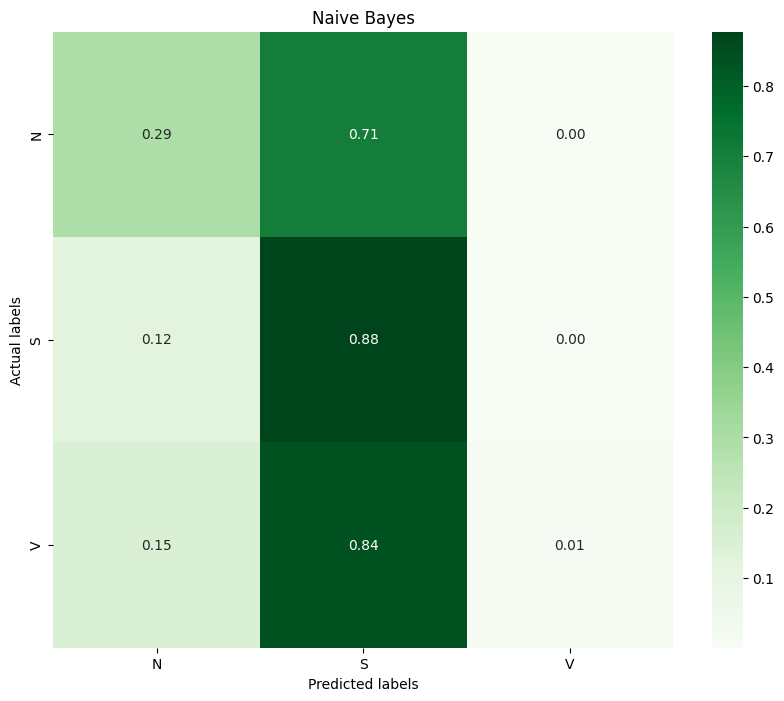

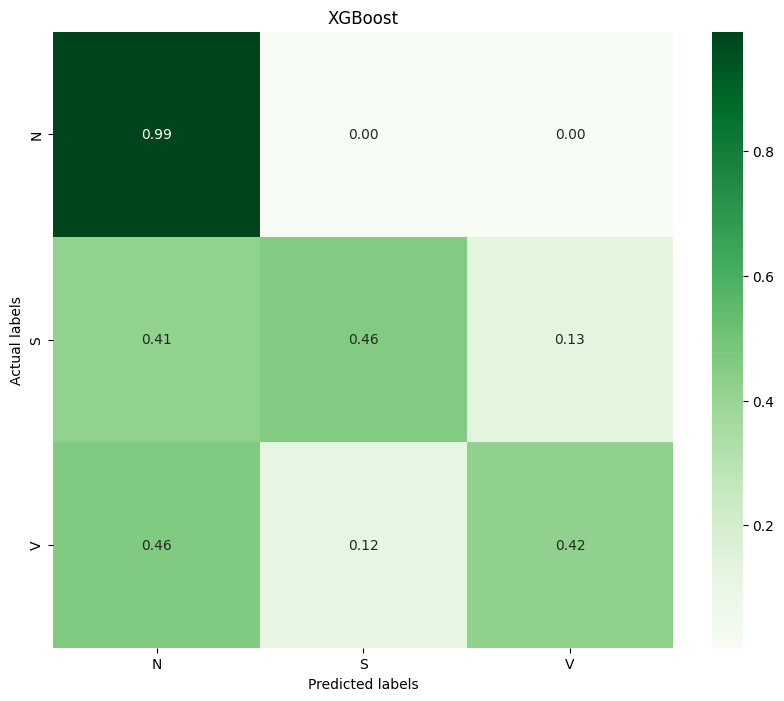

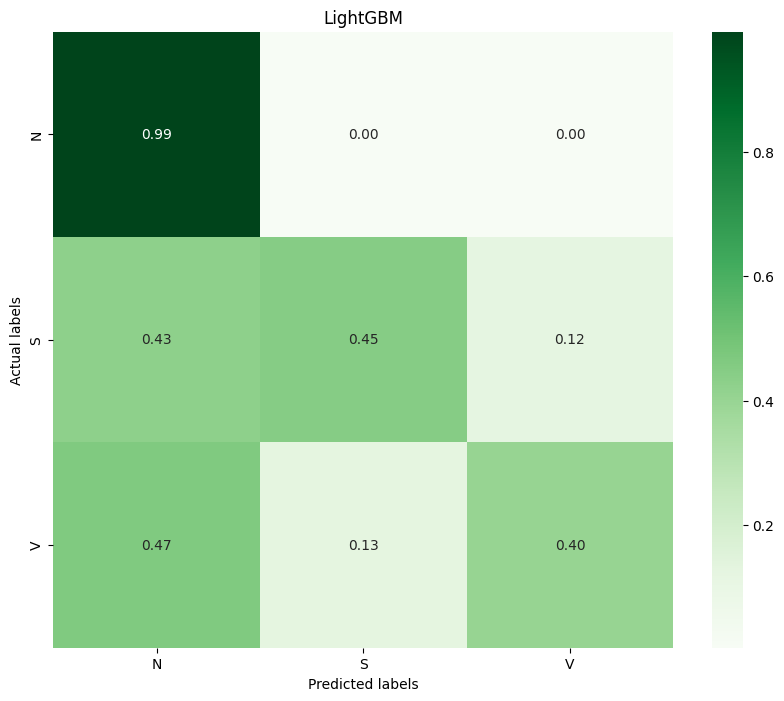

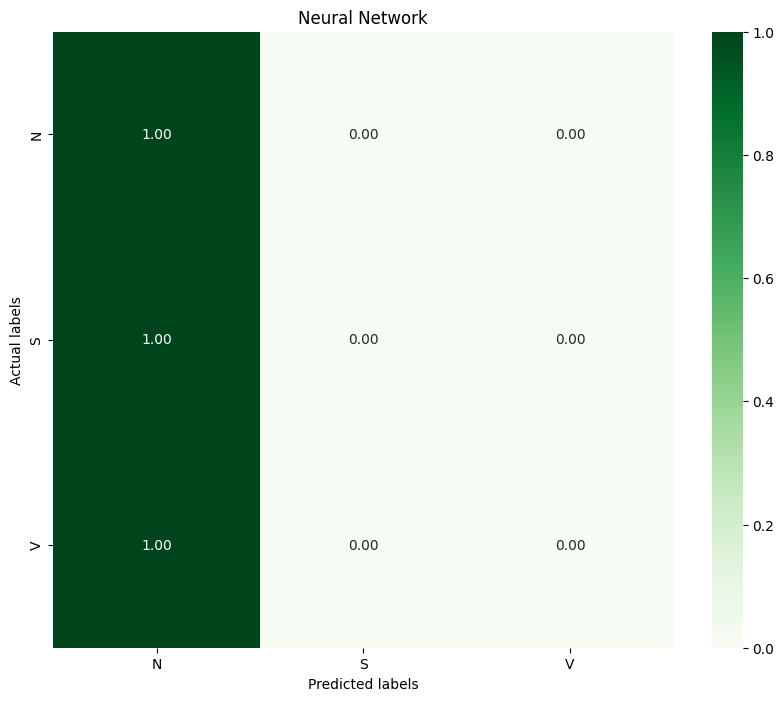

In [81]:
for model_name, model in models.items():
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test) 
    cm = confusion_matrix(y_test, y_pred)
    classes_name = ['N', 'S', 'V']

    #Normalized cm

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Greens", annot=True, fmt='.2f')
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.title(model_name)
    plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
randomForestModel = RandomForestClassifier(n_estimators=100, 
                                              criterion='gini', 
                                              class_weight=class_weights )
randomForestModel.fit(X_train, 
              Y_train)

y_predRanFor = randomForestModel.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_predRanFor)
classes_name = ['N', 'S', 'V']

#Normalized cm

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Greens", annot=True, fmt='.2f')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.title('Random Forest Cri')
plt.show()